## Préambule
Import des modules et personnalisation du notebook.

Import des modules utiles au notebook. Certains sont importés par défaut, on les déclare tout de même par souci de portabilité du code.

In [335]:
import pandas as pd
import numpy as np
from io import StringIO
from itertools import combinations
from IPython.display import display
import math

Personalisation esthétique de la méthode `IPython.display.display()` pour que les chaînes de caractère soient rendues sans double-quotes.

In [336]:
plain = get_ipython().display_formatter.formatters['text/plain']
plain.for_type(str, lambda s, p, c: p.text(s))

<function __main__.<lambda>(s, p, c)>

# Méta-paramètres

Faut-il réaliser les calculs en insérant une roto-translation globale en plus de l'interpolation TPS ?

In [337]:
WITH_ROT_TRANS = True

Paramètre $\lambda$ de la régularisation de Tikhonov utilisé lors de la résolution du système linéaire.
Sa valeur a été fixée visuellement à partir des courbes d'évolution des inconnues du système pour plusieurs valeurs de $\lambda$.
Pour plus d'infos, voir le bloc `Régularisation de Tikhonov`.

Une valeur de `0` désactive la régularisation. 

In [338]:
TIKHONOV_L = 0

# Entrées

## Longueur en mètres d'une toise de l'Académie

**loi du 19 frimaire an VIII (10 décembre 1799)**

> Article Ier « La fixation provisoire de la longueur du mètre à trois pieds onze lignes quarante-quatre centièmes, ordonnée par les lois des 1 er août 1793 et 18 germinal an III demeure révoquée et comme non avenue. Ladite longueur, formant la dix millionième partie de l’arc du méridien terrestre compris entre le pôle nord et l’équateur est définitivement fixée dans son rapport avec les anciennes mesures, à trois pieds onze lignes deux cent quatre-vingt-seize millièmes. »

Source : https://shs.hal.science/halshs-01672844/file/Charbonnier_V3_mesure_de_Paris.pdf

Encore, d'après Delambre dans le tome troisième de "Base du système métrique[...]", p. 665 :
>« Cette détermination a mis les calculateurs en état de conclure de l'arc mesuré entre Dunkerque et Montjouy, l'étendue du quart du méridien terrestre compris entre l'équateur et le pôle boréal; elle est de $5130740$ toises : d'où il suit que sa dix-millionième partie et de 3 pieds 11 lignes $\frac{296}{1000}$. Telle est la longueur du *mètre vrai et définitif*, déduit de la mesure de la terre la plus remarquable, la plus exacte qui ait encore été faite et qui va servir à perfectionner nos connoissances sur la grandeur et la figure du glôbe que nous habitons. Tel est,, pour ce qui concerne le système métrique le résultat d'une des plus vastes entreprises qui aient jamais été exécutées, et qui fait un des plus beaux monumens qu'on ait élevé aux sciences et à la gloire de la Nation française. »

Source : https://gallica.bnf.fr/ark:/12148/bpt6k1106055/f125.item

Douze lignes valant un pouces, douze pouces un pied et six pieds une toise, cela donne le *mètre définitif* à $\frac{13853}{27000}$ toises.

La valeur est donnée par Delambre au millième de ligne, autrement dit à $\frac{27}{864\times13853}$ mètres $\approx$ 3 micromètres.
On considère la longueur d'une toise en mètres avec une précision micrométrique pour rester dans l'ordre de grandeur des mesures originelles.

In [339]:
TOISE_TO_METER = int((27000/13853) * 10**6) / 10**6 # On ignore les décimales après 10**-6.
print("Une toise vaut %s mètres" % TOISE_TO_METER)

Une toise vaut 1.949036 mètres


## Positions des édifices sommets de la triangulation de l'atlas

In [340]:
def readpoints(data: str, sep="\s+", index_col="p" ):
    return pd.read_csv(StringIO(data), sep=sep, index_col=index_col)

In [341]:
GCP = (
    readpoints(
        """
p       x       y
ORIG    0000.0  0000.0
CDTN    2333.2  0687.1
SEDM    0423.2  0586.4
SRBN    0251.6  0689.1
VDGC    0206.7  0239.2
INVD   -0903.8  1065.5
EGSP    0935.8  1036.8
SGRV    0688.7  1094.4
"""
    )
    * TOISE_TO_METER
).join(
    readpoints(
        """
p       u           v
ORIG    651300.0420 6859794.1700  
CDTN    655859.6347 6861090.5194
SEDM    652134.2136 6860929.8364
SRBN    651801.3046 6861132.3735
VDGC    651707.1094 6860257.4406
INVD    649557.3706 6861884.9635
EGSP    653140.6907 6861799.4727
SGRV    652659.7672 6861915.7436
"""
    )
)
GCP

,x,y,u,v
p,,,,
ORIG,0.000000,0.000000,651300.0420,6.859794e+06
CDTN,4547.490795,1339.182636,655859.6347,6.861091e+06
SEDM,824.832035,1142.914710,652134.2136,6.860930e+06
SRBN,490.377458,1343.080708,651801.3046,6.861132e+06
VDGC,402.865741,466.209411,651707.1094,6.860257e+06
INVD,-1761.538737,2076.697858,649557.3706,6.861885e+06
EGSP,1823.907889,2020.760525,653140.6907,6.861799e+06
SGRV,1342.301093,2133.024998,652659.7672,6.861916e+06


In [342]:
n = GCP.shape[0]

In [343]:
def dclochcloch(df: pd.DataFrame):
    """Best function name ever, period."""
    for pair in combinations(df.index, 2):
        s = pair[0]
        t = pair[1]
        d = np.linalg.norm(df.loc[s] - df.loc[t])
        yield {"s": s, "t": t, "d": d}


ds = pd.DataFrame(dclochcloch(GCP[["x", "y"]])).set_index(["s", "t"])
dt = pd.DataFrame(dclochcloch(GCP[["u", "v"]])).set_index(["s", "t"])
D = ds.join(
    dt,
    lsuffix="s",
    rsuffix="t",
)
D

ds           dt
s    t                             
ORIG CDTN  4740.578305  4740.296125
     SEDM  1409.468666  1409.106252
     SRBN  1429.802727  1429.004129
     VDGC   616.159087   616.703751
     INVD  2723.176953  2721.823115
     EGSP  2722.152289  2721.989448
     SGRV  2520.231709  2519.906181
CDTN SEDM  3727.829039  3728.884739
     SRBN  4057.115210  4058.545918
     VDGC  4235.563609  4235.267011
     INVD  6351.990423  6352.139342
     EGSP  2807.570528  2809.852533
     SGRV  3302.033725  3304.564570
SEDM SRBN   389.777232   389.678944
     VDGC   797.487063   796.576493
     INVD  2749.775398  2748.160771
     EGSP  1329.949561  1330.136627
     SGRV  1117.180652  1117.237483
SRBN VDGC   881.227309   879.988815
     INVD  2368.400445  2366.776606
     EGSP  1495.845362  1496.320977
     SGRV  1161.802851  1162.164682
VDGC INVD  2697.836130  2696.332268
     EGSP  2106.178993  2105.473424
     SGRV  1913.325112  1912.465875
INVD EGSP  3585.882944  3584.339774
     SGRV  3104.350888  3102.549287
EGSP SGRV   494.518369   494.779077

## Estimation du facteur d'échelle du plan de Verniquet

In [344]:
K = D["dt"] / D["ds"]
k = K.mean()
std = K.std(ddof=1) / np.sqrt(n)

display(
    "Facteur d'échelle du canvas du plan de Verniquet estimé k = %f (s=%f)" % (k, std)
)

Facteur d'échelle du canvas du plan de Verniquet estimé k = 0.999872 (s=0.000195)

In [345]:
# Mise à l'échelle des points de Verniquet avec le facteur d'échelle estimé
GCP[["x","y"]] *= k
display("Coordonnées mises à l'échelle des points de Verniquet :")
GCP[["x","y"]]

Coordonnées mises à l'échelle des points de Verniquet :

,x,y
p,,
ORIG,0.000000,0.000000
CDTN,4546.908532,1339.011166
SEDM,824.726423,1142.768371
SRBN,490.314669,1342.908739
VDGC,402.814158,466.149717
INVD,-1761.313188,2076.431957
EGSP,1823.674355,2020.501786
SGRV,1342.129224,2132.751885


## Interpolation Thin Plate Spline 2D

### Résolution d'une transformation couplant TPS et roto-translation
La transformation TPS de l'ensemble des points observés par Verniquet corrigés du facteur d'échelle $\mathbf{P_{vern}}$ vers leurs correspondants relevés en Lambert 93 $\mathbf{P_{l93}}$ s'écrit :

$ 
\begin{equation}
\mathbf{F_{tps}} = \mathbf{A} + \mathbf{P_{vern}}\mathbf{B}^\top+\mathbf{\Phi}\mathbf{W}
\end{equation}
$

$\mathbf{F}=\mathbf{P_{l93}} - \mathbf{P_{vern}}$ est la matrice $n \times 2$ des déplacements dans les directions $x$ et $y$.

Les termes $\mathbf{A}$ et $\mathbf{B}$ représentent la part linéaire de la transformation :
- chaque ligne de $\mathbf{A}_{n \times 2}$  contient le vecteur $\begin{bmatrix}a_{x} a_{y}\end{bmatrix}$ des translations en $x$ et $y$.
- $\mathbf{B} = \begin{bmatrix}b_{1x} & b_{2x} \\ b_{1y} & b_{2y} \end{bmatrix}_{2 \times 2}$ contient les coefficients affine.

Le terme $\mathbf{\Phi}\mathbf{W}$ représente la contribution non-rigide de la transformation TPS, correspondant à la somme des éléments de $\mathbf{\Phi}$ pondérée d'un ensembe de poids $\mathbf{W}$. $\mathbf{\Phi}$ est la matrice $n \times n$ contenant les résultats de l'application d'un noyau $\phi$ sur les distances euclidiennes des points $\mathbf{P_{vern}}$ entre eux. Cette matrice incorpore l'information géométrique des points de Verniquet à interpoler.

On choisis comme noyau la fonction de base radiale:
$\begin{equation}
\phi(r) = 
\begin{cases} 
r^2 \log(r) & \text{si } r \neq 0 \\
0 & \text{si } r = 0
\end{cases}
\end{equation}$

À cette interpolation TPS on ajoute une roto-translation comprenant deux termes de translation $(t_x,t_y)$ et une rotation d'angle $\theta$ qui s'écrit :
$ 
\begin{equation}
\mathbf{F_{rt}} = \mathbf{P_{vern}}\mathbf{\Theta}^\top+\mathbf{T}
\end{equation}
$
où :
- $\mathbf{\Theta} = \begin{bmatrix}1 & -\theta \\ \theta & 1\end{bmatrix}$ la matrice de rotation où l'on considère que $\theta$ est suffisamment petit pour que $\sin \theta  \approx \theta$ et $\cos \theta \approx 1$
- $\mathbf{T}$ est la matrice des vecteurs de translation $T = \begin{bmatrix}t_x & t_y \\ t_x & t_y \\ \vdots & \vdots \\ t_x & t_y \end{bmatrix}_{n \times 2}$


La transformation totale devient:

$ 
\begin{equation}
\mathbf{F} = \mathbf{F_{tps}} + \mathbf{F_{rt}}
\end{equation}
$

### Détermination des paramètres de $\mathbf{F_{tps}}$ et $\mathbf{F_{rt}}$
$ 
\begin{equation}
\mathbf{K}\mathbf{x} = \mathbf{l}
\end{equation}
$

$\mathbf{H_{P_{vern}}}  = \begin{bmatrix} \mathbf{1}, \mathbf{P_{vern}} \end{bmatrix}_{n \times 3}$

$
\mathbf{K} = \begin{bmatrix}
\mathbf{\Phi}              & \mathbf{H_{P_{vern}}} & \mathbf{0} & \mathbf{0} & \mathbf{1} & \mathbf{0} & -\mathbf{P_{vern}[:,2]}\\
\mathbf{H_{P_{vern}}^\top} & \mathbf{0}            & \mathbf{0} & \mathbf{0} & \mathbf{0} & \mathbf{0} & \mathbf{0} \\
\mathbf{0}                 & \mathbf{0}            & \mathbf{\Phi}              & \mathbf{H_{P_{vern}}} & \mathbf{0} & \mathbf{1} & \mathbf{P_{vern}[:,1]}\\
\mathbf{0}                 & \mathbf{0}            & \mathbf{H_{P_{vern}}^\top} & \mathbf{0}            & \mathbf{0} & \mathbf{0} & \mathbf{0}
\end{bmatrix}_{(2n+6) \times (2n+9)}
$

$
\mathbf{x} = \begin{bmatrix} \mathbf{w_x} \\ a_x \\ \mathbf{b_x} \\ \mathbf{w_y} \\ a_y \\ \mathbf{b_y} \\ t_x \\ t_y \\ \theta \end{bmatrix}_{(2n+9) \times 1}
$

$\mathbf{l}=\begin{bmatrix} \mathbf{P_{l93}[:,1]} - \mathbf{P_{vern}[:,1]} \\ \mathbf{P_{l93}[:,2]} - \mathbf{P_{vern}[:,2]} \end{bmatrix}_{2n \times 1}$


## Construction du système

In [346]:
# Initialisation : GCP devient un array Numpy pour faciliter les manipulations, on distingue les points sources et les points cibles.
GCP = GCP.values
Pvern = GCP[:, :2]
Pl93 = GCP[:, 2:]
Pvern, Pl93

(array([[    0.        ,     0.        ],
        [ 4546.90853206,  1339.01116594],
        [  824.72642327,  1142.76837099],
        [  490.31466941,  1342.90873883],
        [  402.81415806,   466.1497175 ],
        [-1761.31318844,  2076.4319565 ],
        [ 1823.67435466,  2020.50178555],
        [ 1342.12922425,  2132.75188474]]),
 array([[ 651300.042 , 6859794.17  ],
        [ 655859.6347, 6861090.5194],
        [ 652134.2136, 6860929.8364],
        [ 651801.3046, 6861132.3735],
        [ 651707.1094, 6860257.4406],
        [ 649557.3706, 6861884.9635],
        [ 653140.6907, 6861799.4727],
        [ 652659.7672, 6861915.7436]]))

In [347]:
# Construction de PHI
def phi(R):
    """r^2 * log(r) divide-by-0-proof."""
    log_R = np.zeros_like(R)
    mask = R > 0
    log_R[mask] = np.log(R[mask])
    return R**2 * log_R

PHI = np.linalg.norm(Pvern[:, np.newaxis, :] - Pvern[np.newaxis, :, :], axis=2)
PHI = phi(PHI)
pd.DataFrame(PHI)

,0,1,2,3,4,5,6,7
0,0.000000e+00,1.901587e+08,1.440084e+07,1.484863e+07,2.438024e+06,5.863886e+07,5.859195e+07,4.973260e+07
1,1.901587e+08,0.000000e+00,1.142497e+08,1.367178e+08,1.497811e+08,3.532107e+08,6.257023e+07,8.831875e+07
2,1.440084e+07,1.142497e+08,0.000000e+00,9.060762e+05,4.248147e+06,5.986343e+07,1.271906e+07,8.757414e+06
3,1.484863e+07,1.367178e+08,9.060762e+05,0.000000e+00,5.264661e+06,4.357238e+07,1.635304e+07,9.523810e+06
4,2.438024e+06,1.497811e+08,4.248147e+06,5.264661e+06,0.000000e+00,5.748456e+07,3.393773e+07,2.765574e+07
5,5.863886e+07,3.532107e+08,5.986343e+07,4.357238e+07,5.748456e+07,0.000000e+00,1.052156e+08,7.746576e+07
6,5.859195e+07,6.257023e+07,1.271906e+07,1.635304e+07,3.393773e+07,1.052156e+08,0.000000e+00,1.516657e+06
7,4.973260e+07,8.831875e+07,8.757414e+06,9.523810e+06,2.765574e+07,7.746576e+07,1.516657e+06,0.000000e+00


In [348]:
# Construction de HP_vern
HPvern = np.c_[np.ones((n, 1)), Pvern]
pd.DataFrame(HPvern)

,0,1,2
0,1.0,0.000000,0.000000
1,1.0,4546.908532,1339.011166
2,1.0,824.726423,1142.768371
3,1.0,490.314669,1342.908739
4,1.0,402.814158,466.149717
5,1.0,-1761.313188,2076.431957
6,1.0,1823.674355,2020.501786
7,1.0,1342.129224,2132.751885


In [349]:
# Construction de la partie TPS de K
Ksub = np.r_[
    np.c_[PHI, HPvern],
    np.c_[HPvern.T, np.zeros((3, 3))]
    ]

Ktps = np.r_[
    np.c_[Ksub, np.zeros((n+3,n+3))],
    np.c_[np.zeros((n+3,n+3)), Ksub],
]

pd.DataFrame(Ksub)

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000e+00,1.901587e+08,1.440084e+07,1.484863e+07,2.438024e+06,5.863886e+07,5.859195e+07,4.973260e+07,1.0,0.000000,0.000000
1,1.901587e+08,0.000000e+00,1.142497e+08,1.367178e+08,1.497811e+08,3.532107e+08,6.257023e+07,8.831875e+07,1.0,4546.908532,1339.011166
2,1.440084e+07,1.142497e+08,0.000000e+00,9.060762e+05,4.248147e+06,5.986343e+07,1.271906e+07,8.757414e+06,1.0,824.726423,1142.768371
3,1.484863e+07,1.367178e+08,9.060762e+05,0.000000e+00,5.264661e+06,4.357238e+07,1.635304e+07,9.523810e+06,1.0,490.314669,1342.908739
4,2.438024e+06,1.497811e+08,4.248147e+06,5.264661e+06,0.000000e+00,5.748456e+07,3.393773e+07,2.765574e+07,1.0,402.814158,466.149717
5,5.863886e+07,3.532107e+08,5.986343e+07,4.357238e+07,5.748456e+07,0.000000e+00,1.052156e+08,7.746576e+07,1.0,-1761.313188,2076.431957
6,5.859195e+07,6.257023e+07,1.271906e+07,1.635304e+07,3.393773e+07,1.052156e+08,0.000000e+00,1.516657e+06,1.0,1823.674355,2020.501786
7,4.973260e+07,8.831875e+07,8.757414e+06,9.523810e+06,2.765574e+07,7.746576e+07,1.516657e+06,0.000000e+00,1.0,1342.129224,2132.751885
8,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,0.000000,0.000000
9,0.000000e+00,4.546909e+03,8.247264e+02,4.903147e+02,4.028142e+02,-1.761313e+03,1.823674e+03,1.342129e+03,0.0,0.000000,0.000000


In [350]:
# Construction de l le vecteur des déplacements entre les points de Verniquet en Lambert 93 et en référentiel Verniquet métrique.
l = np.r_[Pl93 - Pvern, np.zeros((3, 2))].T.ravel()
l, l.shape

(array([ 651300.042     ,  651312.72616794,  651309.48717673,
         651310.98993059,  651304.29524194,  651318.68378844,
         651317.01634534,  651317.63797575,       0.        ,
              0.        ,       0.        , 6859794.17      ,
        6859751.50823406, 6859787.06802901, 6859789.46476117,
        6859791.2908825 , 6859808.5315435 , 6859778.97091445,
        6859782.99171526,       0.        ,       0.        ,
              0.        ]),
 (22,))

In [351]:
# Incorporation de la roto-translation si nécessaire
if WITH_ROT_TRANS:
    Krt = np.r_[ 
            np.c_[np.ones((n, 1)), np.zeros((n, 1)), -GCP[:,1]],
            np.zeros((3, 3)),
            np.c_[np.zeros((n, 1)), np.ones((n, 1)), GCP[:,0]],
            np.zeros((3, 3)),
        ]
    K = np.c_[Ktps, Krt]
else:
    K = Ktps
pd.DataFrame(K)


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000000e+00,1.901587e+08,1.440084e+07,1.484863e+07,2.438024e+06,5.863886e+07,5.859195e+07,4.973260e+07,1.0,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,1.0,0.0,-0.000000
1,1.901587e+08,0.000000e+00,1.142497e+08,1.367178e+08,1.497811e+08,3.532107e+08,6.257023e+07,8.831875e+07,1.0,4546.908532,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,1.0,0.0,-1339.011166
2,1.440084e+07,1.142497e+08,0.000000e+00,9.060762e+05,4.248147e+06,5.986343e+07,1.271906e+07,8.757414e+06,1.0,824.726423,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,1.0,0.0,-1142.768371
3,1.484863e+07,1.367178e+08,9.060762e+05,0.000000e+00,5.264661e+06,4.357238e+07,1.635304e+07,9.523810e+06,1.0,490.314669,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,1.0,0.0,-1342.908739
4,2.438024e+06,1.497811e+08,4.248147e+06,5.264661e+06,0.000000e+00,5.748456e+07,3.393773e+07,2.765574e+07,1.0,402.814158,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,1.0,0.0,-466.149717
5,5.863886e+07,3.532107e+08,5.986343e+07,4.357238e+07,5.748456e+07,0.000000e+00,1.052156e+08,7.746576e+07,1.0,-1761.313188,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,1.0,0.0,-2076.431957
6,5.859195e+07,6.257023e+07,1.271906e+07,1.635304e+07,3.393773e+07,1.052156e+08,0.000000e+00,1.516657e+06,1.0,1823.674355,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,1.0,0.0,-2020.501786
7,4.973260e+07,8.831875e+07,8.757414e+06,9.523810e+06,2.765574e+07,7.746576e+07,1.516657e+06,0.000000e+00,1.0,1342.129224,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,1.0,0.0,-2132.751885
8,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.0,0.000000
9,0.000000e+00,4.546909e+03,8.247264e+02,4.903147e+02,4.028142e+02,-1.761313e+03,1.823674e+03,1.342129e+03,0.0,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.0,0.000000


## Régularisation de Tikhonov

In [352]:
# K est-elles mal conditionnée ?
display("Valeur de conditionnement de la matrice K : cond(K) = %f" % np.linalg.cond(K))

Valeur de conditionnement de la matrice K : cond(K) = 243391709235903648.000000

In [353]:
def regularized_lstsq(A, B, l2=0.0):
    if l2 > 0:
        # print("Regularisation with λ = %f" % l2)
        # Ajout des termes de régularisation L2
        REG = np.sqrt(l2) * np.eye(A.shape[1])
        Areg = np.vstack((A, REG))
        Breg = np.append(B, np.zeros(A.shape[1]))
    else:
        Areg = A
        Breg = B
    return np.linalg.lstsq(Areg, Breg, rcond=None)

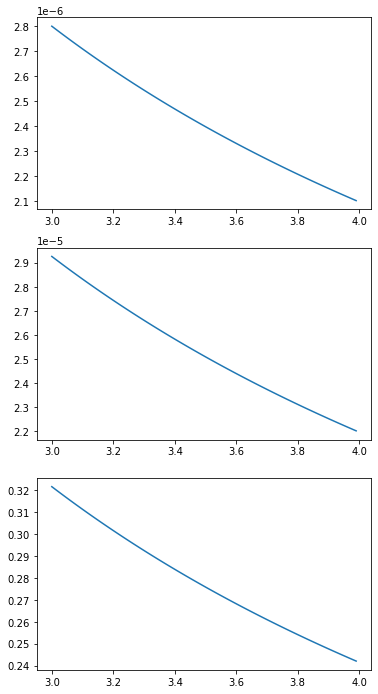

In [354]:
# Trace the evolution de la magnitude des coefficients en fonction de lambda
coeffs = []
rng = np.arange(3, 4, 0.01)
for lambda_ in rng:
    X, *_ = regularized_lstsq(K, l, lambda_)
    coeffs.append(X[-3:])

import matplotlib.pyplot as plt

coeffs = np.vstack(coeffs).T

# Décommenter pour afficher les graphes
n_rows, n_cols = coeffs.shape
fig, axes = plt.subplots(n_rows, 1, figsize=(6, n_rows * 4))
for i, c in enumerate(coeffs):
    axes[i].plot(rng, c)

## Résolution du système

In [355]:
x, R, rank, S = regularized_lstsq(K,l, l2=TIKHONOV_L)

display(
    {
        "Least-square solution": x,
        "Residuals": l - K.dot(x),
        "Rank of K": rank,
        "Singular values of K": S,
    }
)

{Least-square solution: array([ 2.12471776e-03,  3.60910247e-03, -1.31356357e-04, -4.13573157e-03,
        -3.58692748e-03,  3.75274281e-03, -5.28158559e-03,  2.54252484e-03,
         4.71401354e-03,  2.50194855e+01,  1.03578262e+02,  2.23825417e-02,
         3.80128461e-02, -1.38325809e-03, -4.35570845e-02, -3.77857208e-02,
         3.95249052e-02, -5.56300651e-02,  2.67813530e-02,  1.60603715e-02,
         1.83544882e+02,  2.48602595e+02,  4.71484815e-03,  1.60603715e-02,
         7.99666199e+01]),
 Residuals: array([ 0.00000000e+00, -1.16415322e-10,  1.86264515e-08, -2.33994797e-08,
        -2.09547579e-09,  1.28056854e-09, -1.49011612e-08,  1.53668225e-08,
         1.10651311e-03, -3.86450205e-09,  5.24768149e-08, -1.53295696e-06,
        -4.24683094e-07, -2.88709998e-08,  2.31899321e-07, -9.56468284e-07,
         8.72649252e-07,  1.00675970e-06,  1.15670264e-06,  1.16544827e-02,
        -4.47714378e-07, -4.22447357e-07]),
 Rank of K: 20,
 Singular values of K: array([5.84792366e+0

In [356]:
tpsx = x[: n + 3]
tpsy = x[n + 3 : 2 * n + 6]
W = np.c_[tpsx[:n], tpsy[:n]]
B = np.c_[tpsx[-2:], tpsy[-2:]]
A = np.c_[tpsx[-3], tpsy[-3]]
print(
    """
    -------------------------------
    TERMES DE LA TPS
    -------------------------------
    Wx : %s
    Wy : %s
    ax : %s
    ay : %s
    bx : %s
    by : %s
    """
    % (
        W[:, 0],
        W[:, 1],
        A[:, 0],
        A[:, 1],
        B[:, 0],
        B[:, 1],
    )
)

RT = x[2 * n + 6 : 2 * n + 9]
print(
    """
    -------------------------------
    TERMES DE LA ROTO-TRANSLATION
    -------------------------------
    Tx = %f m
    Ty = %f m
    θ  = %f rad
    """
    % (RT[0], RT[1], RT[2] % math.pi)
)


    -------------------------------
    TERMES DE LA TPS
    -------------------------------
    Wx : [ 0.00212472  0.0036091  -0.00013136 -0.00413573 -0.00358693  0.00375274
 -0.00528159  0.00254252]
    Wy : [ 0.02238254  0.03801285 -0.00138326 -0.04355708 -0.03778572  0.03952491
 -0.05563007  0.02678135]
    ax : [0.00471401]
    ay : [0.01606037]
    bx : [ 25.01948547 103.57826181]
    by : [183.5448816 248.6025945]
    

    -------------------------------
    TERMES DE LA ROTO-TRANSLATION
    -------------------------------
    Tx = 0.004715 m
    Ty = 0.016060 m
    θ  = 1.426804 rad
    


In [357]:
# Application sur les points de Verniquet pour valider

# W.T @ PHI est la matrice (2, n) contenant la somme des poids multipliés par les distance pour chaque point, en x (1ere ligne) et y (2e ligne)
F = A + Pvern @ B + PHI @ W + Pvern
if WITH_ROT_TRANS:
    F += np.fliplr(Pvern) * [-RT[2], RT[2]] + RT[:2]
    
for p in F:
    print("POINT(%f %f)" % (p[0], p[1]))

POINT(651300.042000 6859794.170002)
POINT(655859.634700 6861090.519400)
POINT(652134.213600 6860929.836400)
POINT(651801.304600 6861132.373500)
POINT(651707.109400 6860257.440601)
POINT(649557.370600 6861884.963499)
POINT(653140.690700 6861799.472699)
POINT(652659.767200 6861915.743599)


# Expérimentation avec PROJ

In [358]:
GCP = (
    readpoints(
        """
p       x       y
ORIG    0000.0  0000.0
CDTN    2333.2  0687.1
SEDM    0423.2  0586.4
SRBN    0251.6  0689.1
VDGC    0206.7  0239.2
INVD   -0903.8  1065.5
EGSP    0935.8  1036.8
SGRV    0688.7  1094.4
"""
    )
    * TOISE_TO_METER
).join(
    readpoints(
        """
p       u           v
ORIG    651300.0420 6859794.1700  
CDTN    655859.6347 6861090.5194
SEDM    652134.2136 6860929.8364
SRBN    651801.3046 6861132.3735
VDGC    651707.1094 6860257.4406
INVD    649557.3706 6861884.9635
EGSP    653140.6907 6861799.4727
SGRV    652659.7672 6861915.7436
"""
    )
)
n = GCP.shape[0]
GCP

,x,y,u,v
p,,,,
ORIG,0.000000,0.000000,651300.0420,6.859794e+06
CDTN,4547.490795,1339.182636,655859.6347,6.861091e+06
SEDM,824.832035,1142.914710,652134.2136,6.860930e+06
SRBN,490.377458,1343.080708,651801.3046,6.861132e+06
VDGC,402.865741,466.209411,651707.1094,6.860257e+06
INVD,-1761.538737,2076.697858,649557.3706,6.861885e+06
EGSP,1823.907889,2020.760525,653140.6907,6.861799e+06
SGRV,1342.301093,2133.024998,652659.7672,6.861916e+06


In [359]:
from pyproj import CRS, Transformer

crs_verniquet_meters = CRS.from_proj4(
    "+proj=aeqd +lat_0=48.83635863 +lon_0=2.33652533 +x_0=0 +y_0=0 +ellps=GRS80 +no_defs"
)
crs_l93 = CRS.from_epsg(2154)

t = Transformer.from_crs(crs_l93,crs_verniquet_meters)
r = [t.transform(*p) for p in GCP[["u","v"]].values]
GCP[["u", "v"]] = r
GCP

,x,y,u,v
p,,,,
ORIG,0.000000,0.000000,0.000071,0.000656
CDTN,4547.490795,1339.182636,4549.055341,1334.839622
SEDM,824.832035,1142.914710,824.694550,1142.773377
SRBN,490.377458,1343.080708,490.056525,1342.527467
VDGC,402.865741,466.209411,403.208552,466.731992
INVD,-1761.538737,2076.697858,-1760.368428,2076.327370
EGSP,1823.907889,2020.760525,1823.933314,2020.942459
SGRV,1342.301093,2133.024998,1341.996367,2133.175620


In [360]:
K = pd.DataFrame(dclochcloch(GCP[["u","v"]]))["d"] / pd.DataFrame(dclochcloch(GCP[["x","y"]]))["d"]
k = K.mean()
std = K.std(ddof=1) / np.sqrt(n)

display(
    "Facteur d'échelle du canvas du plan de Verniquet estimé k = %f (s=%f)" % (k, std)
)

Facteur d'échelle du canvas du plan de Verniquet estimé k = 0.999985 (s=0.000195)

In [361]:
GCP = GCP.values
GCP[:, :2] *= k
pd.DataFrame(GCP)

,0,1,2,3
0,0.000000,0.000000,0.000071,0.000656
1,4547.424754,1339.163187,4549.055341,1334.839622
2,824.820057,1142.898112,824.694550,1142.773377
3,490.370336,1343.061203,490.056525,1342.527467
4,402.859891,466.202641,403.208552,466.731992
5,-1761.513155,2076.667699,-1760.368428,2076.327370
6,1823.881401,2020.731178,1823.933314,2020.942459
7,1342.281600,2132.994021,1341.996367,2133.175620


In [362]:
K = np.r_[
    np.c_[np.ones((n, 1)), np.zeros((n, 1)), -GCP[:, 1]],  # x'-x = tx - y * theta
    np.c_[np.zeros((n, 1)), np.ones((n, 1)), GCP[:, 0]],  # y'-y = ty + x * theta
]

display("Valeur de conditionnement de la matrice K : cond(K) = %f" % np.linalg.cond(K))

T = (GCP[:, 2:] - GCP[:, :2]).T.ravel()

X, R, rank, S = regularized_lstsq(K, T, l2=TIKHONOV_L)
print(
    "Paramètres affine de la transformation des points de Verniquet vers les points de Verniquet relevés en L93 et projetés dans le SCR Verniquet"
)
print("Tx(m) = %f" % (X[0]))
print("Ty(m) = %f" % (X[1]))
print("Theta(rad) = %f" % (X[2]))
print("k = %f" % (k))

for p in GCP[:, :2]:
    print("POINT( %f %f)" % (p[0] + X[0] - p[1] * X[2], p[1] + X[1] + p[0] * X[2]))

Valeur de conditionnement de la matrice K : cond(K) = 3278.099877

Paramètres affine de la transformation des points de Verniquet vers les points de Verniquet relevés en L93 et projetés dans le SCR Verniquet
Tx(m) = -0.417897
Ty(m) = -0.021918
Theta(rad) = -0.000551
k = 0.999985
POINT( -0.417897 -0.021918)
POINT( 4547.744369 1336.636883)
POINT( 825.031583 1142.421945)
POINT( 490.692098 1342.769225)
POINT( 402.698743 465.958858)
POINT( -1760.787377 2077.615893)
POINT( 1824.576374 2019.704801)
POINT( 1343.038398 2132.232874)


# Expérimentation chaînage RT / TPS

In [363]:
GCP = (
    readpoints(
        """
p       x       y
ORIG    0000.0  0000.0
CDTN    2333.2  0687.1
SEDM    0423.2  0586.4
SRBN    0251.6  0689.1
VDGC    0206.7  0239.2
INVD   -0903.8  1065.5
EGSP    0935.8  1036.8
SGRV    0688.7  1094.4
"""
    )
    * TOISE_TO_METER
).join(
    readpoints(
        """
p       u           v
ORIG    651300.0420 6859794.1700  
CDTN    655859.6347 6861090.5194
SEDM    652134.2136 6860929.8364
SRBN    651801.3046 6861132.3735
VDGC    651707.1094 6860257.4406
INVD    649557.3706 6861884.9635
EGSP    653140.6907 6861799.4727
SGRV    652659.7672 6861915.7436
"""
    )
)
n = GCP.shape[0]
GCP = GCP.values
pd.DataFrame(GCP)

,0,1,2,3
0,0.000000,0.000000,651300.0420,6.859794e+06
1,4547.490795,1339.182636,655859.6347,6.861091e+06
2,824.832035,1142.914710,652134.2136,6.860930e+06
3,490.377458,1343.080708,651801.3046,6.861132e+06
4,402.865741,466.209411,651707.1094,6.860257e+06
5,-1761.538737,2076.697858,649557.3706,6.861885e+06
6,1823.907889,2020.760525,653140.6907,6.861799e+06
7,1342.301093,2133.024998,652659.7672,6.861916e+06


In [364]:
# Mise à l'échelle
GCP[:, :2] *= k

# Translation par barycentres
bs = np.mean(GCP[:, :2], axis=0)
bt = np.mean(GCP[:, 2:], axis=0)
delta = bt - bs
GCP[:,2:] -= delta

In [365]:
b = (GCP[:, 2:] - GCP[:, :2]).T.ravel()
a = np.hstack((-GCP[:, 1], GCP[:, 0]))

X, R, rank, S = np.linalg.lstsq(a[:, np.newaxis], b, rcond=None)
X

array([-0.00500995])

In [366]:
x = GCP[:,0] + X * -GCP[:,1]
y = GCP[:,1] + X * GCP[:,0]
GCP[:,0] = x
GCP[:,1] = y
GCP

array([[    0.        ,     0.        ,   -11.20898962,     8.81979271],
       [ 4554.13389375,  1316.38081976,  4548.38371038,  1305.16919271],
       [  830.54591815,  1138.7658057 ,   822.96261038,  1144.48619271],
       [  497.09900461,  1340.60447213,   490.05361038,  1347.02329271],
       [  405.19554216,   464.18433302,   395.85841038,   472.09039271],
       [-1751.10915487,  2085.49279068, -1753.88038962,  2099.61329271],
       [ 1834.00516179,  2011.59362485,  1829.43971038,  2014.12249271],
       [ 1352.9677915 ,  2126.26925868,  1348.51621038,  2130.39339271]])

In [367]:
# Construction de la partie TPS de K
HPvern = np.c_[np.ones((n, 1)), GCP[:, :2]]
Ksub = np.r_[np.c_[PHI, HPvern], np.c_[HPvern.T, np.zeros((3, 3))]]

Ktps = np.r_[
    np.c_[Ksub, np.zeros((n + 3, n + 3))],
    np.c_[np.zeros((n + 3, n + 3)), Ksub],
]


l = np.r_[GCP[:, 2:] - GCP[:, :2], np.zeros((3, 2))].T.ravel()

x, R, rank, S = regularized_lstsq(Ktps, l)

display(
    {
        "Least-square solution": x,
        "Residuals": l - Ktps.dot(x),
        "Rank of K": rank,
        "Singular values of K": S,
    }
)
tpsx = x[: n + 3]
tpsy = x[n + 3 : 2 * n + 6]
W = np.c_[tpsx[:n], tpsy[:n]]
B = np.c_[tpsx[-2:], tpsy[-2:]]
A = np.c_[tpsx[-3], tpsy[-3]]
print(
    """
    -------------------------------
    TERMES DE LA TPS
    -------------------------------
    Wx : %s
    Wy : %s
    ax : %s
    ay : %s
    bx : %s
    by : %s
    """
    % (
        W[:, 0],
        W[:, 1],
        A[:, 0],
        A[:, 1],
        B[:, 0],
        B[:, 1],
    )
)

{Least-square solution: array([-4.58663822e-07, -7.78122454e-08, -2.30674943e-08, -2.41598340e-07,
         7.74570147e-07,  1.25812456e-08,  2.87530927e-07, -2.40604508e-07,
         7.00351880e-08, -8.34333734e-04,  2.83642709e-03, -3.87771817e-07,
        -1.20353465e-08, -2.01004489e-08, -9.91438443e-07,  9.22494529e-07,
         1.40276892e-07,  4.41100075e-08,  2.62607499e-07, -8.98259568e-08,
        -3.18688360e-03,  9.20019269e-04]),
 Residuals: array([ 3.73034936e-14, -8.88178420e-15, -3.90798505e-14,  4.44089210e-14,
         2.13162821e-14,  5.32907052e-15, -2.66453526e-15, -3.81916720e-14,
        -3.29359094e-08,  1.27104040e-12,  1.18710705e-12,  3.90798505e-14,
        -3.37507799e-14, -2.48689958e-14, -3.90798505e-14, -1.24344979e-14,
        -1.77635684e-15, -5.15143483e-14, -5.32907052e-14,  4.18571286e-08,
        -1.61532289e-12, -1.50865399e-12]),
 Rank of K: 20,
 Singular values of K: array([5.84792366e+08, 5.84792366e+08, 4.14299008e+08, 4.14299008e+08,
        


    -------------------------------
    TERMES DE LA TPS
    -------------------------------
    Wx : [-4.58663822e-07 -7.78122454e-08 -2.30674943e-08 -2.41598340e-07
  7.74570147e-07  1.25812456e-08  2.87530927e-07 -2.40604508e-07]
    Wy : [-3.87771817e-07 -1.20353465e-08 -2.01004489e-08 -9.91438443e-07
  9.22494529e-07  1.40276892e-07  4.41100075e-08  2.62607499e-07]
    ax : [7.0035188e-08]
    ay : [-8.98259568e-08]
    bx : [-0.00083433  0.00283643]
    by : [-0.00318688  0.00092002]
    
